In [115]:
import os
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [116]:
images_path_train = r"images/train/"
images_path_valid = r"images/valid/"
images_path_test = r"images/test/"
labels = os.listdir(images_path_train)
labels

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(
        directory=images_path_train,
        target_size=(224, 224),
        classes=labels,
        batch_size=10
    )
valid_batches = ImageDataGenerator().flow_from_directory(
        directory=images_path_valid,
        target_size=(224, 224),
        classes=labels,
        batch_size=10
    )
test_batches = ImageDataGenerator().flow_from_directory(
        directory=images_path_test,
        target_size=(224, 224),
        classes=labels,
        batch_size=10,
        shuffle=True
    )

In [86]:
imgs, _ = next(train_batches)

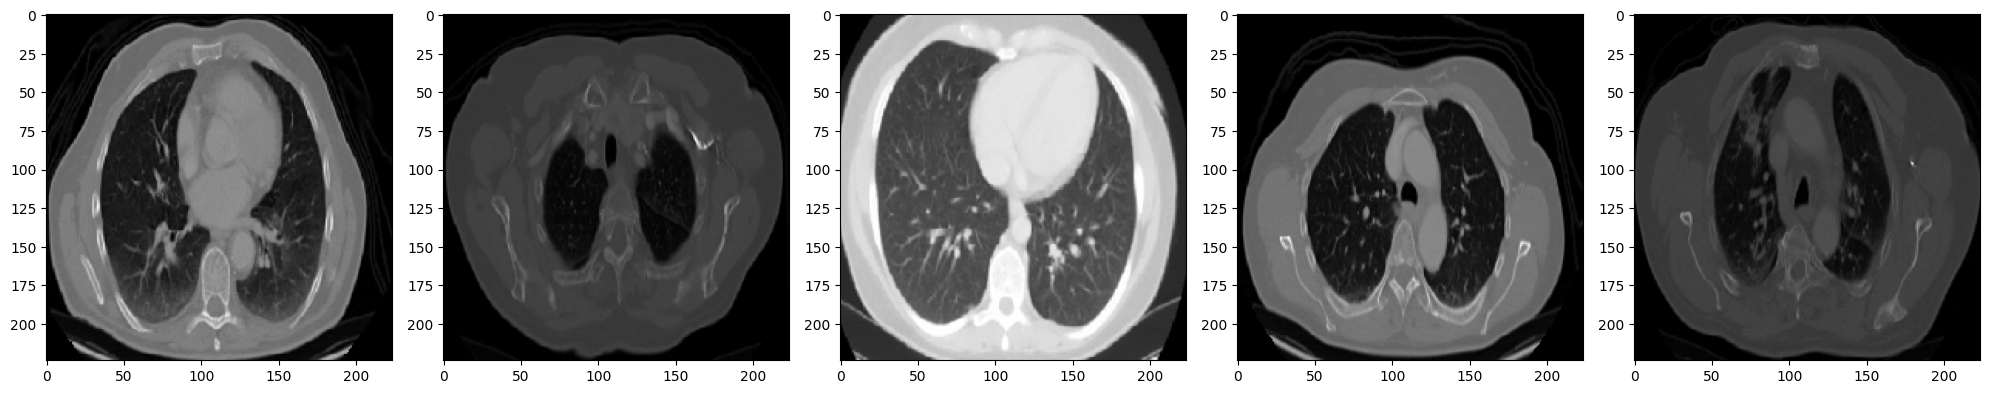

In [87]:
# Näytetään viisi esimerkkikuvaa
fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(imgs, axes):
    ax.imshow(img.astype("uint8"))
plt.tight_layout()
plt.show()

In [70]:
# Luodaan neuroverkkomalli
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=4, activation='softmax')
])

In [71]:
# Tarkastellaan neuroverkon osia tarkemmin
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                

In [72]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
%%time
# Opetetaan malli
model.fit(x=train_batches, validation_data=valid_batches, epochs=20, verbose=2)

Epoch 1/20


62/62 - 16s - loss: 42.1478 - accuracy: 0.4845 - val_loss: 6.6241 - val_accuracy: 0.5556 - 16s/epoch - 260ms/step
Epoch 2/20
62/62 - 15s - loss: 2.5179 - accuracy: 0.7830 - val_loss: 9.1742 - val_accuracy: 0.5417 - 15s/epoch - 236ms/step
Epoch 3/20
62/62 - 14s - loss: 0.6523 - accuracy: 0.9135 - val_loss: 4.5300 - val_accuracy: 0.5833 - 14s/epoch - 230ms/step
Epoch 4/20
62/62 - 15s - loss: 0.4321 - accuracy: 0.9674 - val_loss: 1.9288 - val_accuracy: 0.7500 - 15s/epoch - 241ms/step
Epoch 5/20
62/62 - 16s - loss: 0.2071 - accuracy: 0.9837 - val_loss: 2.6529 - val_accuracy: 0.6528 - 16s/epoch - 250ms/step
Epoch 6/20
62/62 - 15s - loss: 0.5017 - accuracy: 0.9592 - val_loss: 1.7874 - val_accuracy: 0.7917 - 15s/epoch - 234ms/step
Epoch 7/20
62/62 - 15s - loss: 0.6464 - accuracy: 0.9511 - val_loss: 5.4145 - val_accuracy: 0.6389 - 15s/epoch - 235ms/step
Epoch 8/20
62/62 - 14s - loss: 0.4780 - accuracy: 0.9657 - val_loss: 2.8050 - val_accuracy: 0.7361 - 14s/epoch - 232ms/step
Epoch

In [ ]:
# Tallennetaan malli
with open('model.pickle', 'wb') as file:
    pickle.dump(model, file)

In [118]:
# Ladataan malli
with open('model.pickle', 'rb') as file:
    model = pickle.load(file)

In [119]:
# Tuodaan muutama kuva näytille
test_imgs, test_labels = next(test_batches)

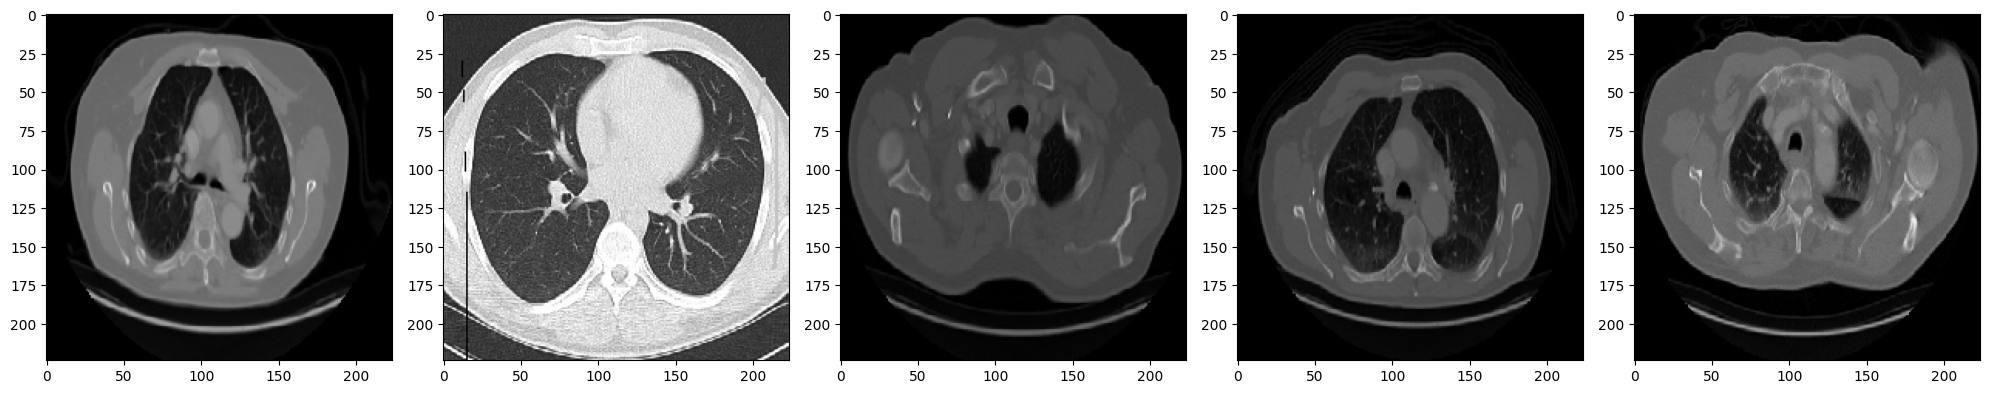

In [126]:
# Tulostetaan testikuvat
fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(test_imgs, axes):
    ax.imshow(img.astype("uint8"))
plt.tight_layout()
plt.show()

In [147]:
# Tulostetaan label:it ulos ja katsotaan ennusteet
predictions = model.predict(x=test_batches, verbose=0)

for label in np.round(predictions):
    for i, num in enumerate(label):
        if num == 1:
            # Selvitetään kuinka tarkkaan malli ennusti syövän
            label_index = labels.index(labels[i])
            pred_index = np.where(label == 1.0)[0][0]
            print("Oikein: {} - {} - {} - {} - {}".format(
                                             pred_index == label_index,
                                             pred_index,
                                             label,
                                             label_index,
                                             labels[i])
                                             )


Oikein: True - 1 - [0. 1. 0. 0.] - 1 - large.cell.carcinoma
Oikein: True - 2 - [0. 0. 1. 0.] - 2 - normal
Oikein: True - 2 - [0. 0. 1. 0.] - 2 - normal
Oikein: True - 2 - [0. 0. 1. 0.] - 2 - normal
Oikein: True - 1 - [0. 1. 0. 0.] - 1 - large.cell.carcinoma
Oikein: True - 3 - [0. 0. 0. 1.] - 3 - squamous.cell.carcinoma
Oikein: True - 0 - [1. 0. 0. 0.] - 0 - adenocarcinoma
Oikein: True - 1 - [0. 1. 0. 0.] - 1 - large.cell.carcinoma
Oikein: True - 2 - [0. 0. 1. 0.] - 2 - normal
Oikein: True - 3 - [0. 0. 0. 1.] - 3 - squamous.cell.carcinoma
Oikein: True - 3 - [0. 0. 0. 1.] - 3 - squamous.cell.carcinoma
Oikein: True - 2 - [0. 0. 1. 0.] - 2 - normal
Oikein: True - 1 - [0. 1. 0. 0.] - 1 - large.cell.carcinoma
Oikein: True - 2 - [0. 0. 1. 0.] - 2 - normal
Oikein: True - 3 - [0. 0. 0. 1.] - 3 - squamous.cell.carcinoma
Oikein: True - 1 - [0. 1. 0. 0.] - 1 - large.cell.carcinoma
Oikein: True - 3 - [0. 0. 0. 1.] - 3 - squamous.cell.carcinoma
Oikein: True - 1 - [0. 1. 0. 0.] - 1 - large.cell.carci

[0. 0. 0. 1.]


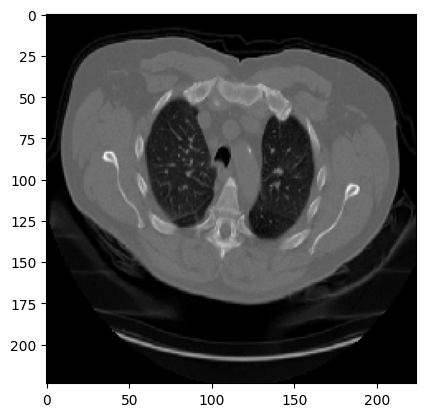

In [155]:
images, _ = next(test_batches)
print(_[0])
plt.imshow(images[0].astype("uint8"))